In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier


def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y
#https://www.kaggleusercontent.com/kf/9346645/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..95xX9r5WTHA0fG1XzurVxg.QZyr_n6gQwFUHwG4ZEdnGzLWZT1CYVtBzfzTXGL2bcazjfkY-iuEmG5fdBF7nhVO-orKEuOfmdcCo4P-fa3FrpMqmzq-xVy-rS-BkufBNOnNZtKNcGKc85dUitewo3rWT2GlTOjbihgG8g-WiFOd4A.R87ccA0SVNBFjWiYeZ6yCg/__results__.html#purpose

Using TensorFlow backend.


In [107]:
#load data
df=pd.read_csv('Admission_Predict.csv')

(400, 8)
   GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research  \
0        337          118                  4  4.5   4.5  9.65         1   
1        324          107                  4  4.0   4.5  8.87         1   
2        316          104                  3  3.0   3.5  8.00         1   
3        322          110                  3  3.5   2.5  8.67         1   
4        314          103                  2  2.0   3.0  8.21         0   

   Chance of Admit   
0              0.92  
1              0.76  
2              0.72  
3              0.80  
4              0.65  


   GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research  \
0        337          118                  4  4.5   4.5  9.65         1   
1        324          107                  4  4.0   4.5  8.87         1   
2        316          104                  3  3.0   3.5  8.00         1   
3        322          110                  3  3.5   2.5  8.67         1   
4        314          103                  2  2.0   3.0  8.21         0   

   Chance of Admit   
0              0.92  
1              0.76  
2              0.72  
3              0.80  
4              0.65  
(400, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
GRE Score            400 non-null int64
TOEFL Score          400 non-null int64
University Rating    400 non-null int64
SOP                  400 non-null float64
LOR                  400 non-null float64
CGPA                 400 non-null float64
Research             400 non-null int64
Chance of Admit   

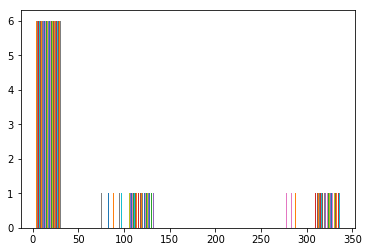

<Figure size 288x576 with 0 Axes>

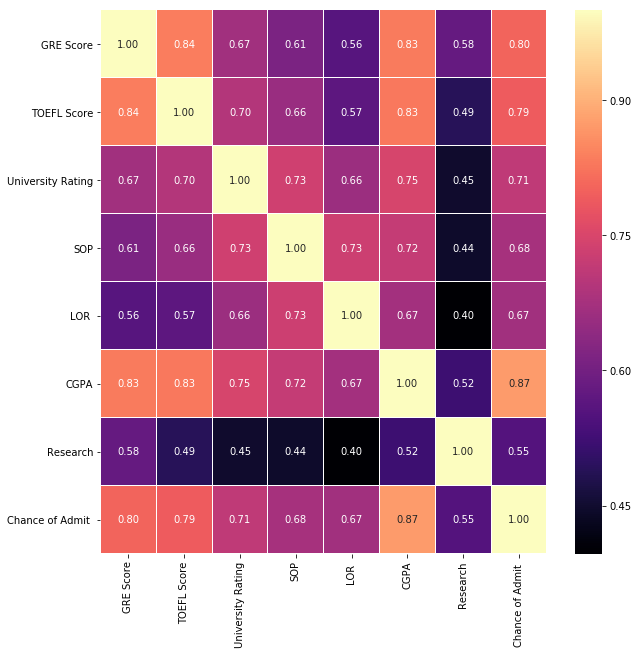

In [115]:
#Explore data

print(df.head())
print(df.shape)
print(df.info()) #tell us the total number of non null observations
df.describe() #display a summary statistics
df.isnull().sum() #total number of NaN
#data_name[‘column_name’].replace(0, np.nan, inplace= True) #replace Nan --> or "Filling missing values with a test statistic" (https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d)
#data_name.dropna()

histogram=plt.hist(df)
plt.figure(figsize=(4, 8))
fig,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
df.info()



Not Having Research: 181
Having Research: 219


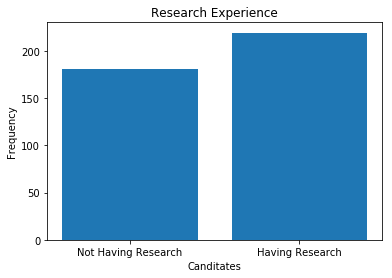

In [114]:
#DATA VISUALIZATION TO UNDERSTAND THE DATASET

print("Not Having Research:",len(df[df.Research == 0]))
print("Having Research:",len(df[df.Research == 1]))
y = np.array([len(df[df.Research == 0]),len(df[df.Research == 1])])
x = ["Not Having Research","Having Research"]
plt.bar(x,y)
plt.title("Research Experience")
plt.xlabel("Canditates")
plt.ylabel("Frequency")
plt.show()

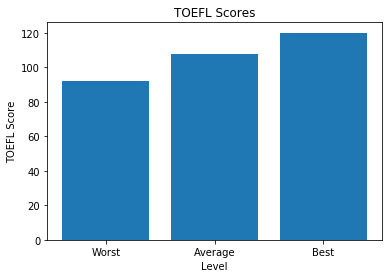

In [116]:
y = np.array([df["TOEFL Score"].min(),df["TOEFL Score"].mean(),df["TOEFL Score"].max()])
x = ["Worst","Average","Best"]
plt.bar(x,y)
plt.title("TOEFL Scores")
plt.xlabel("Level")
plt.ylabel("TOEFL Score")
plt.show()

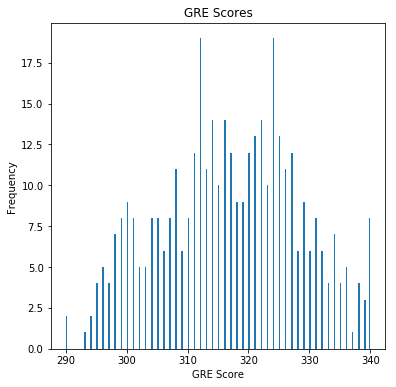

In [117]:
df["GRE Score"].plot(kind = 'hist',bins = 200,figsize = (6,6))
plt.title("GRE Scores")
plt.xlabel("GRE Score")
plt.ylabel("Frequency")
plt.show()

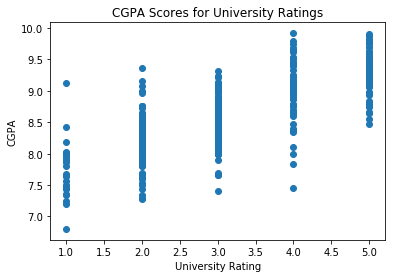

In [118]:
plt.scatter(df["University Rating"],df.CGPA)
plt.title("CGPA Scores for University Ratings")
plt.xlabel("University Rating")
plt.ylabel("CGPA")
plt.show()

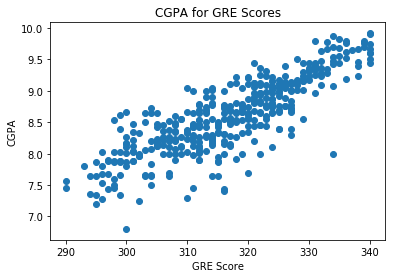

In [119]:
plt.scatter(df["GRE Score"],df.CGPA)
plt.title("CGPA for GRE Scores")
plt.xlabel("GRE Score")
plt.ylabel("CGPA")
plt.show()

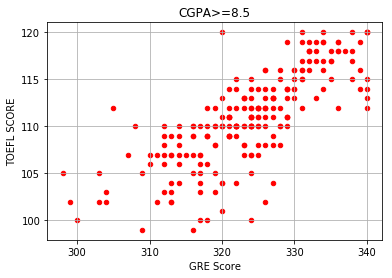

In [120]:
df[df.CGPA >= 8.5].plot(kind='scatter', x='GRE Score', y='TOEFL Score',color="red")
plt.xlabel("GRE Score")
plt.ylabel("TOEFL SCORE")
plt.title("CGPA>=8.5")
plt.grid(True)
plt.show()

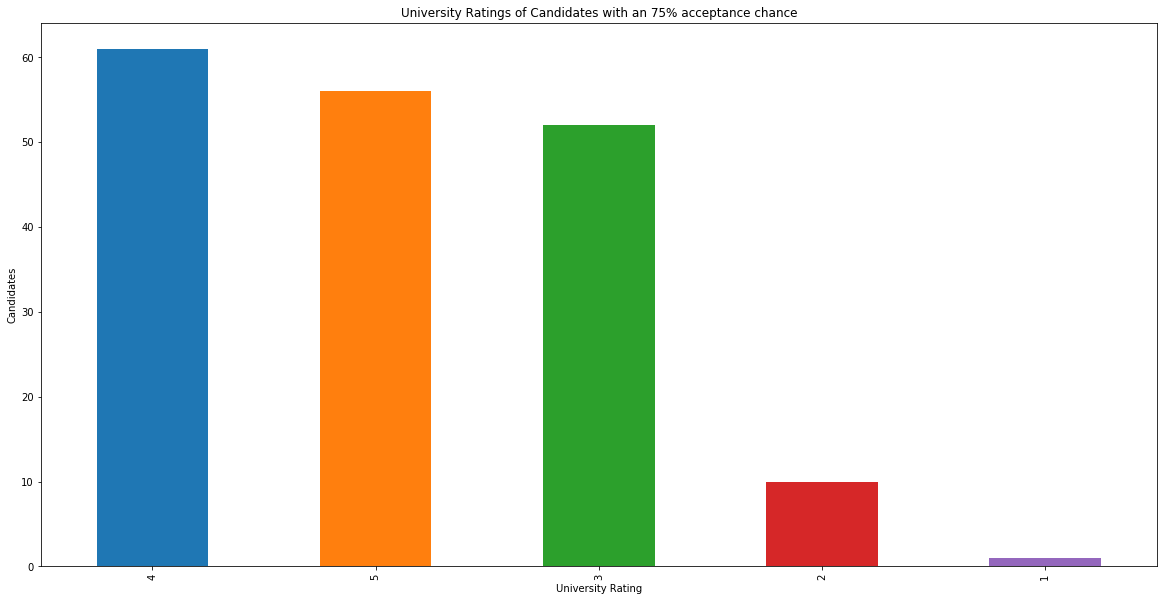

In [122]:
s = df[df["Chance of Admit "] >= 0.75]["University Rating"].value_counts().head(5)
plt.title("University Ratings of Candidates with an 75% acceptance chance")
s.plot(kind='bar',figsize=(20, 10))
plt.xlabel("University Rating")
plt.ylabel("Candidates")
plt.show()

In [123]:
#Preprocessing Data Before Regression

#train.drop(columns=['Serial No.'],axis=1,inplace=True) #Dropping
#test=pd.read_csv('drugsComTest_raw.csv',usecols = ['drugName','condition','rating','usefulCount']) #Using col.
df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'}) #change names

In [124]:
#Normalization - making all values (0,1)

y = df["Chance of Admit"].values
x_data = df.drop(["Chance of Admit"],axis=1) #all but chance of admit
x = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data)) #Scaling with ( x-min(x) )/ ( max(x)-min(x) )

In [130]:
#Split data into .8 training and .2 testing
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size = 0.20 ,random_state = 42)

In [131]:
#Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [132]:
#Predict
y_head_lr = lr.predict(x_test)
print("real value of y_test[1]: " + str(y_test[1]) + " -> the predict: " + str(lr.predict(x_test.iloc[[1],:])))
print("real value of y_test[2]: " + str(y_test[2]) + " -> the predict: " + str(lr.predict(x_test.iloc[[2],:])))

real value of y_test[1]: 0.68 -> the predict: [0.72368741]
real value of y_test[2]: 0.9 -> the predict: [0.93536809]


In [133]:
#R^2 score
from sklearn.metrics import r2_score
print("r_square score: ", r2_score(y_test,y_head_lr))

y_head_lr_train = lr.predict(x_train)
print("r_square score (train dataset): ", r2_score(y_train,y_head_lr_train))

r_square score:  0.8212082591486991
r_square score (train dataset):  0.7951946003191085


In [134]:
#Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators = 100, random_state = 42)
rfr.fit(x_train,y_train)
y_head_rfr = rfr.predict(x_test) 

from sklearn.metrics import r2_score
print("r_square score: ", r2_score(y_test,y_head_rfr))
print("real value of y_test[1]: " + str(y_test[1]) + " -> the predict: " + str(rfr.predict(x_test.iloc[[1],:])))
print("real value of y_test[2]: " + str(y_test[2]) + " -> the predict: " + str(rfr.predict(x_test.iloc[[2],:])))


y_head_rf_train = rfr.predict(x_train)
print("r_square score (train dataset): ", r2_score(y_train,y_head_rf_train))

r_square score:  0.8074111823415694
real value of y_test[1]: 0.68 -> the predict: [0.7249]
real value of y_test[2]: 0.9 -> the predict: [0.9407]
r_square score (train dataset):  0.9634880602889714


In [135]:
#Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state = 42)
dtr.fit(x_train,y_train)
y_head_dtr = dtr.predict(x_test) 

from sklearn.metrics import r2_score
print("r_square score: ", r2_score(y_test,y_head_dtr))
print("real value of y_test[1]: " + str(y_test[1]) + " -> the predict: " + str(dtr.predict(x_test.iloc[[1],:])))
print("real value of y_test[2]: " + str(y_test[2]) + " -> the predict: " + str(dtr.predict(x_test.iloc[[2],:])))

y_head_dtr_train = dtr.predict(x_train)
print("r_square score (train dataset): ", r2_score(y_train,y_head_dtr_train))

r_square score:  0.6262105228127393
real value of y_test[1]: 0.68 -> the predict: [0.73]
real value of y_test[2]: 0.9 -> the predict: [0.94]
r_square score (train dataset):  1.0


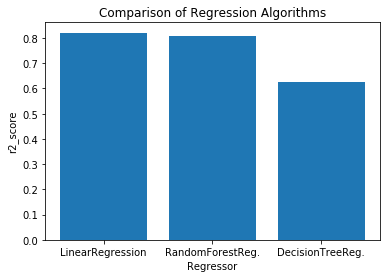

In [136]:
#Comparison of Regression Algorithms
y = np.array([r2_score(y_test,y_head_lr),r2_score(y_test,y_head_rfr),r2_score(y_test,y_head_dtr)])
x = ["LinearRegression","RandomForestReg.","DecisionTreeReg."]
plt.bar(x,y)
plt.title("Comparison of Regression Algorithms")
plt.xlabel("Regressor")
plt.ylabel("r2_score")
plt.show()

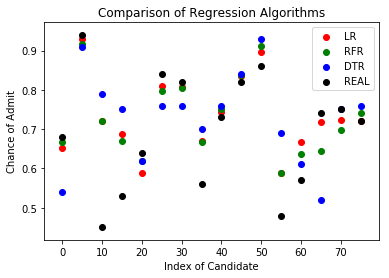

In [137]:
red = plt.scatter(np.arange(0,80,5),y_head_lr[0:80:5],color = "red")
green = plt.scatter(np.arange(0,80,5),y_head_rfr[0:80:5],color = "green")
blue = plt.scatter(np.arange(0,80,5),y_head_dtr[0:80:5],color = "blue")
black = plt.scatter(np.arange(0,80,5),y_test[0:80:5],color = "black")
plt.title("Comparison of Regression Algorithms")
plt.xlabel("Index of Candidate")
plt.ylabel("Chance of Admit")
plt.legend((red,green,blue,black),('LR', 'RFR', 'DTR', 'REAL'))
plt.show()

score:  0.9
real value of y_test_01[1]: 0 -> the predict: [0]
real value of y_test_01[2]: 1 -> the predict: [1]


c:\users\sagi\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


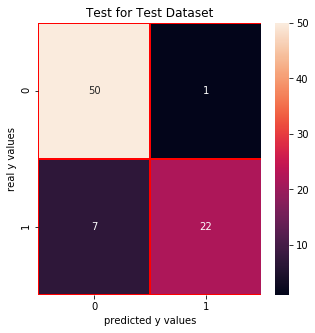

precision_score:  0.9565217391304348
recall_score:  0.7586206896551724
f1_score:  0.8461538461538461


In [144]:
#Logistic Regression

# reading the dataset
df = pd.read_csv("Admission_Predict.csv",sep = ",")

# it may be needed in the future.
serialNo = df["Serial No."].values
df.drop(["Serial No."],axis=1,inplace = True)

df=df.rename(columns = {'Chance of Admit ':'Chance of Admit'})

# normalization
y = df["Chance of Admit"].values
x_data = df.drop(["Chance of Admit"],axis=1)
x = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data))

# separating train (80%) and test (%20) sets
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(x,y,test_size = 0.20,random_state = 42)

y_train_01 = [1 if each > 0.8 else 0 for each in y_train]
y_test_01  = [1 if each > 0.8 else 0 for each in y_test]

# list to array
y_train_01 = np.array(y_train_01)
y_test_01 = np.array(y_test_01)

#L.R
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression()
lrc.fit(x_train,y_train_01)
print("score: ", lrc.score(x_test,y_test_01))
print("real value of y_test_01[1]: " + str(y_test_01[1]) + " -> the predict: " + str(lrc.predict(x_test.iloc[[1],:])))
print("real value of y_test_01[2]: " + str(y_test_01[2]) + " -> the predict: " + str(lrc.predict(x_test.iloc[[2],:])))

# confusion matrix
from sklearn.metrics import confusion_matrix
cm_lrc = confusion_matrix(y_test_01,lrc.predict(x_test))
# print("y_test_01 == 1 :" + str(len(y_test_01[y_test_01==1]))) # 29

# cm visualization
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lrc,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.show()


from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test_01,lrc.predict(x_test)))
print("recall_score: ", recall_score(y_test_01,lrc.predict(x_test)))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test_01,lrc.predict(x_test)))

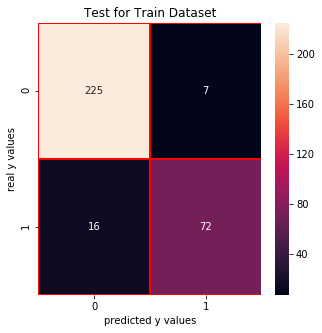

In [145]:
#Testing the train dataset
cm_lrc_train = confusion_matrix(y_train_01,lrc.predict(x_train))
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lrc_train,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.title("Test for Train Dataset")
plt.show()

score:  0.9
real value of y_test_01[1]: 0 -> the predict: [0]
real value of y_test_01[2]: 1 -> the predict: [1]


c:\users\sagi\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


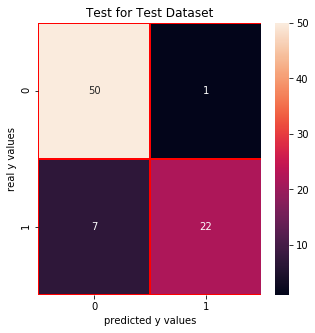

precision_score:  0.9565217391304348
recall_score:  0.7586206896551724
f1_score:  0.8461538461538461


In [147]:
#Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state = 1)
svm.fit(x_train,y_train_01)
print("score: ", svm.score(x_test,y_test_01))
print("real value of y_test_01[1]: " + str(y_test_01[1]) + " -> the predict: " + str(svm.predict(x_test.iloc[[1],:])))
print("real value of y_test_01[2]: " + str(y_test_01[2]) + " -> the predict: " + str(svm.predict(x_test.iloc[[2],:])))

# confusion matrix
from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_test_01,svm.predict(x_test))
# print("y_test_01 == 1 :" + str(len(y_test_01[y_test_01==1]))) # 29

# cm visualization
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.show()

from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test_01,svm.predict(x_test)))
print("recall_score: ", recall_score(y_test_01,svm.predict(x_test)))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test_01,svm.predict(x_test)))

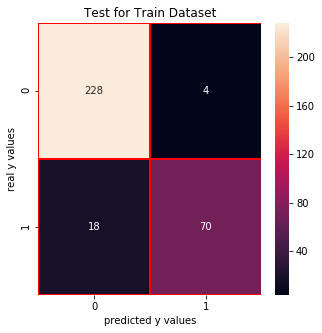

In [148]:
#Testing the training dataset
cm_svm_train = confusion_matrix(y_train_01,svm.predict(x_train))
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm_train,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.title("Test for Train Dataset")
plt.show()

score:  0.9625
real value of y_test_01[1]: 0 -> the predict: [0]
real value of y_test_01[2]: 1 -> the predict: [1]


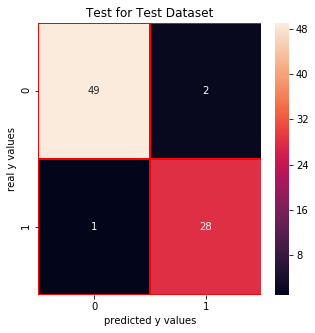

precision_score:  0.9333333333333333
recall_score:  0.9655172413793104
f1_score:  0.9491525423728815


In [150]:
#Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train,y_train_01)
print("score: ", nb.score(x_test,y_test_01))
print("real value of y_test_01[1]: " + str(y_test_01[1]) + " -> the predict: " + str(nb.predict(x_test.iloc[[1],:])))
print("real value of y_test_01[2]: " + str(y_test_01[2]) + " -> the predict: " + str(nb.predict(x_test.iloc[[2],:])))

# confusion matrix
from sklearn.metrics import confusion_matrix
cm_nb = confusion_matrix(y_test_01,nb.predict(x_test))
# print("y_test_01 == 1 :" + str(len(y_test_01[y_test_01==1]))) # 29
# cm visualization
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_nb,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.show()

from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test_01,nb.predict(x_test)))
print("recall_score: ", recall_score(y_test_01,nb.predict(x_test)))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test_01,nb.predict(x_test)))

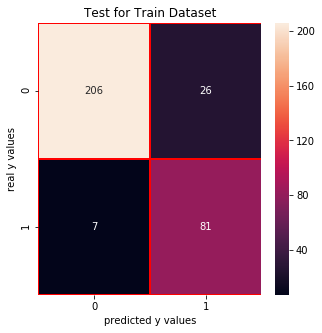

In [151]:
#Testing the training dataset
cm_nb_train = confusion_matrix(y_train_01,nb.predict(x_train))
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_nb_train,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.title("Test for Train Dataset")
plt.show()

score:  0.95
real value of y_test_01[1]: 0 -> the predict: [0]
real value of y_test_01[2]: 1 -> the predict: [1]


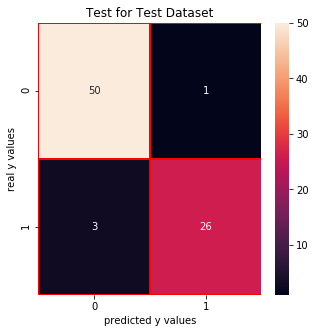

precision_score:  0.9629629629629629
recall_score:  0.896551724137931
f1_score:  0.9285714285714286


In [152]:
#Decision Tree Classification
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train_01)
print("score: ", dtc.score(x_test,y_test_01))
print("real value of y_test_01[1]: " + str(y_test_01[1]) + " -> the predict: " + str(dtc.predict(x_test.iloc[[1],:])))
print("real value of y_test_01[2]: " + str(y_test_01[2]) + " -> the predict: " + str(dtc.predict(x_test.iloc[[2],:])))

# confusion matrix
from sklearn.metrics import confusion_matrix
cm_dtc = confusion_matrix(y_test_01,dtc.predict(x_test))
# print("y_test_01 == 1 :" + str(len(y_test_01[y_test_01==1]))) # 29

# cm visualization
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_dtc,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.show()

from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test_01,dtc.predict(x_test)))
print("recall_score: ", recall_score(y_test_01,dtc.predict(x_test)))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test_01,dtc.predict(x_test)))

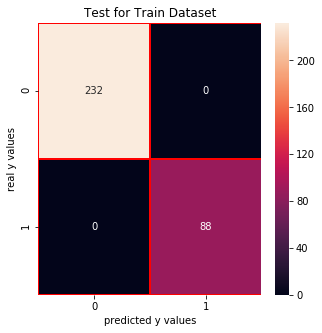

In [153]:
#Train
cm_dtc_train = confusion_matrix(y_train_01,dtc.predict(x_train))
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_dtc_train,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.title("Test for Train Dataset")
plt.show()

score:  0.9375
real value of y_test_01[1]: 0 -> the predict: [0]
real value of y_test_01[2]: 1 -> the predict: [1]


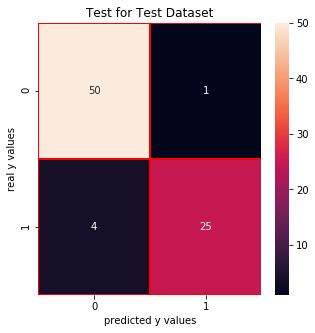

precision_score:  0.9615384615384616
recall_score:  0.8620689655172413
f1_score:  0.9090909090909091


In [154]:
#Random Forest Classification
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100,random_state = 1)
rfc.fit(x_train,y_train_01)
print("score: ", rfc.score(x_test,y_test_01))
print("real value of y_test_01[1]: " + str(y_test_01[1]) + " -> the predict: " + str(rfc.predict(x_test.iloc[[1],:])))
print("real value of y_test_01[2]: " + str(y_test_01[2]) + " -> the predict: " + str(rfc.predict(x_test.iloc[[2],:])))

# confusion matrix
from sklearn.metrics import confusion_matrix
cm_rfc = confusion_matrix(y_test_01,rfc.predict(x_test))
# print("y_test_01 == 1 :" + str(len(y_test_01[y_test_01==1]))) # 29
# cm visualization
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.show()

from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test_01,rfc.predict(x_test)))
print("recall_score: ", recall_score(y_test_01,rfc.predict(x_test)))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test_01,rfc.predict(x_test)))

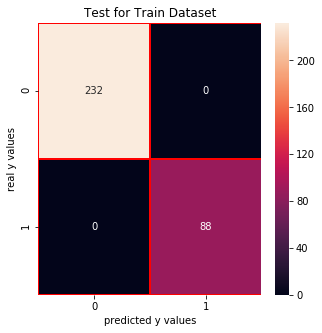

In [155]:
#Train
cm_rfc_train = confusion_matrix(y_train_01,rfc.predict(x_train))
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc_train,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.title("Test for Train Dataset")
plt.show()

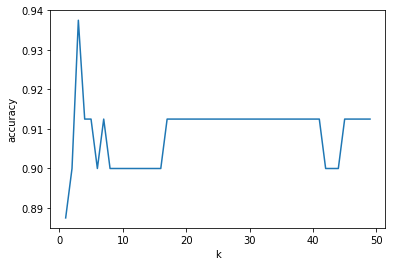

score of 3 : 0.9375
real value of y_test_01[1]: 0 -> the predict: [0]
real value of y_test_01[2]: 1 -> the predict: [1]


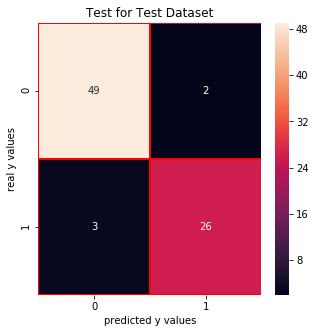

precision_score:  0.9285714285714286
recall_score:  0.896551724137931
f1_score:  0.912280701754386


In [156]:
#K Nearest Neighbors Classification
from sklearn.neighbors import KNeighborsClassifier

# finding k value
scores = []
for each in range(1,50):
    knn_n = KNeighborsClassifier(n_neighbors = each)
    knn_n.fit(x_train,y_train_01)
    scores.append(knn_n.score(x_test,y_test_01))
    
plt.plot(range(1,50),scores)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.show()

knn = KNeighborsClassifier(n_neighbors = 3) # n_neighbors = k
knn.fit(x_train,y_train_01)
print("score of 3 :",knn.score(x_test,y_test_01))
print("real value of y_test_01[1]: " + str(y_test_01[1]) + " -> the predict: " + str(knn.predict(x_test.iloc[[1],:])))
print("real value of y_test_01[2]: " + str(y_test_01[2]) + " -> the predict: " + str(knn.predict(x_test.iloc[[2],:])))

# confusion matrix
from sklearn.metrics import confusion_matrix
cm_knn = confusion_matrix(y_test_01,knn.predict(x_test))
# print("y_test_01 == 1 :" + str(len(y_test_01[y_test_01==1]))) # 29

# cm visualization
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_knn,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.title("Test for Test Dataset")
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.show()

from sklearn.metrics import precision_score, recall_score
print("precision_score: ", precision_score(y_test_01,knn.predict(x_test)))
print("recall_score: ", recall_score(y_test_01,knn.predict(x_test)))

from sklearn.metrics import f1_score
print("f1_score: ",f1_score(y_test_01,knn.predict(x_test)))

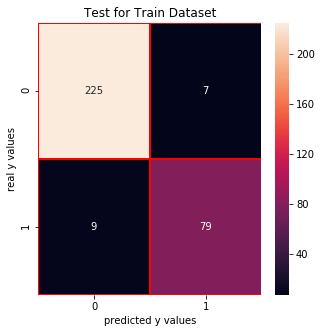

In [157]:
#Train
cm_knn_train = confusion_matrix(y_train_01,knn.predict(x_train))
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_knn_train,annot = True,linewidths=0.5,linecolor="red",fmt = ".0f",ax=ax)
plt.xlabel("predicted y values")
plt.ylabel("real y values")
plt.title("Test for Train Dataset")
plt.show()

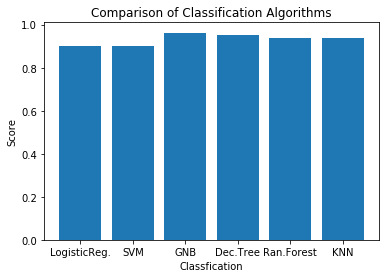

In [158]:
#Comparison of Classification Algorithms

y = np.array([lrc.score(x_test,y_test_01),svm.score(x_test,y_test_01),nb.score(x_test,y_test_01),dtc.score(x_test,y_test_01),rfc.score(x_test,y_test_01),knn.score(x_test,y_test_01)])
#x = ["LogisticRegression","SVM","GaussianNB","DecisionTreeClassifier","RandomForestClassifier","KNeighborsClassifier"]
x = ["LogisticReg.","SVM","GNB","Dec.Tree","Ran.Forest","KNN"]

plt.bar(x,y)
plt.title("Comparison of Classification Algorithms")
plt.xlabel("Classfication")
plt.ylabel("Score")
plt.show()

In [159]:
#CLUSTERING ALGORITHMS (UNSUPERVISED MACHINE LEARNING ALGORITHMS)

#Preparing Data for Clustering
df = pd.read_csv("Admission_Predict.csv",sep = ",")
df=df.rename(columns = {'Chance of Admit ':'ChanceOfAdmit'})
serial = df["Serial No."]
df.drop(["Serial No."],axis=1,inplace = True)
df = (df- np.min(df))/(np.max(df)-np.min(df))
y = df.ChanceOfAdmit 
x = df.drop(["ChanceOfAdmit"],axis=1)

In [161]:
# for data visualization
from sklearn.decomposition import PCA
pca = PCA(n_components = 1, whiten= True )  # whitten = normalize
pca.fit(x)
x_pca = pca.transform(x)
x_pca = x_pca.reshape(400,)
dictionary = {"x":x_pca,"y":y}
data = pd.DataFrame(dictionary)
print("data:")
print(data.head())
print("\ndf:")
print(df.head())

data:
          x         y
0 -1.377553  0.920635
1 -0.919033  0.666667
2 -0.320986  0.603175
3 -0.520960  0.730159
4  1.137743  0.492063

df:
   GRE Score  TOEFL Score  University Rating    SOP   LOR       CGPA  \
0       0.94     0.928571               0.75  0.875  0.875  0.913462   
1       0.68     0.535714               0.75  0.750  0.875  0.663462   
2       0.52     0.428571               0.50  0.500  0.625  0.384615   
3       0.64     0.642857               0.50  0.625  0.375  0.599359   
4       0.48     0.392857               0.25  0.250  0.500  0.451923   

   Research  ChanceOfAdmit  Serial No.  label_kmeans  
0       1.0       0.920635           1             0  
1       1.0       0.666667           2             0  
2       1.0       0.603175           3             2  
3       1.0       0.730159           4             2  
4       0.0       0.492063           5             1  


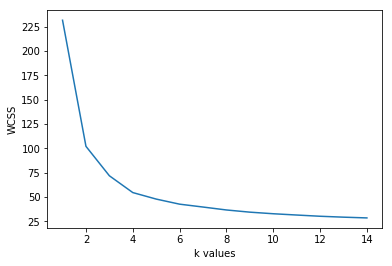

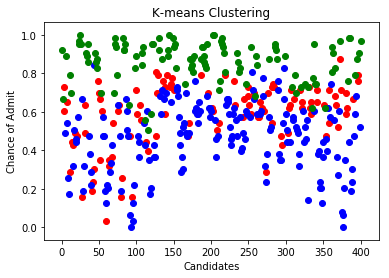

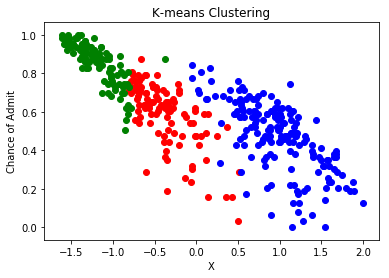

In [162]:
#K-means Clustering
#The elbow method is used to determine the best number of clusters for k-means clustering. The number is 3.

df["Serial No."] = serial
from sklearn.cluster import KMeans
wcss = []
for k in range(1,15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15),wcss)
plt.xlabel("k values")
plt.ylabel("WCSS")
plt.show()

kmeans = KMeans(n_clusters=3)
clusters_knn = kmeans.fit_predict(x)

df["label_kmeans"] = clusters_knn


plt.scatter(df[df.label_kmeans == 0 ]["Serial No."],df[df.label_kmeans == 0].ChanceOfAdmit,color = "red")
plt.scatter(df[df.label_kmeans == 1 ]["Serial No."],df[df.label_kmeans == 1].ChanceOfAdmit,color = "blue")
plt.scatter(df[df.label_kmeans == 2 ]["Serial No."],df[df.label_kmeans == 2].ChanceOfAdmit,color = "green")
plt.title("K-means Clustering")
plt.xlabel("Candidates")
plt.ylabel("Chance of Admit")
plt.show()

df["label_kmeans"] = clusters_knn
plt.scatter(data.x[df.label_kmeans == 0 ],data[df.label_kmeans == 0].y,color = "red")
plt.scatter(data.x[df.label_kmeans == 1 ],data[df.label_kmeans == 1].y,color = "blue")
plt.scatter(data.x[df.label_kmeans == 2 ],data[df.label_kmeans == 2].y,color = "green")
plt.title("K-means Clustering")
plt.xlabel("X")
plt.ylabel("Chance of Admit")
plt.show()

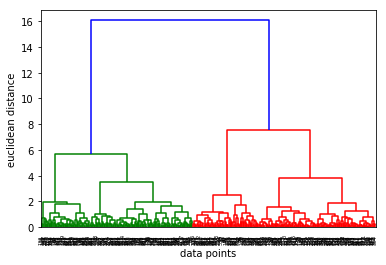

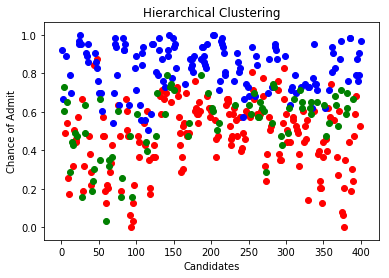

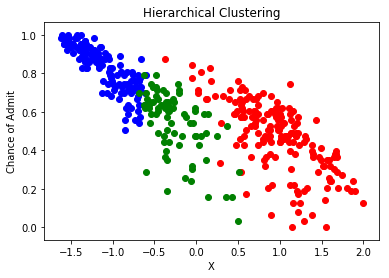

In [163]:
#Hierarchical Clustering
#The dendrogram method is used to determine the best number of clusters for hierarchical clustering. The number is 3 again.
df["Serial No."] = serial

from scipy.cluster.hierarchy import linkage, dendrogram
merg = linkage(x,method="ward")
dendrogram(merg,leaf_rotation = 90)
plt.xlabel("data points")
plt.ylabel("euclidean distance")
plt.show()

from sklearn.cluster import AgglomerativeClustering
hiyerartical_cluster = AgglomerativeClustering(n_clusters = 3,affinity= "euclidean",linkage = "ward")
clusters_hiyerartical = hiyerartical_cluster.fit_predict(x)

df["label_hiyerartical"] = clusters_hiyerartical

plt.scatter(df[df.label_hiyerartical == 0 ]["Serial No."],df[df.label_hiyerartical == 0].ChanceOfAdmit,color = "red")
plt.scatter(df[df.label_hiyerartical == 1 ]["Serial No."],df[df.label_hiyerartical == 1].ChanceOfAdmit,color = "blue")
plt.scatter(df[df.label_hiyerartical == 2 ]["Serial No."],df[df.label_hiyerartical == 2].ChanceOfAdmit,color = "green")
plt.title("Hierarchical Clustering")
plt.xlabel("Candidates")
plt.ylabel("Chance of Admit")
plt.show()

plt.scatter(data[df.label_hiyerartical == 0 ].x,data.y[df.label_hiyerartical == 0],color = "red")
plt.scatter(data[df.label_hiyerartical == 1 ].x,data.y[df.label_hiyerartical == 1],color = "blue")
plt.scatter(data[df.label_hiyerartical == 2 ].x,data.y[df.label_hiyerartical == 2],color = "green")
plt.title("Hierarchical Clustering")
plt.xlabel("X")
plt.ylabel("Chance of Admit")
plt.show()

In [165]:
#Comparison of Clustering Algorithms
#K-means Clustering and Hierarchical Clustering are similarly.